# Time benchmark KDE

In [1]:
from abc import ABC, abstractmethod
from dataclasses import dataclass

import numpy as np
import pandas as pd

import time
from itertools import cycle

from scipy.stats import norm
from scipy.stats import multivariate_normal

from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from KDEpy.FFTKDE import FFTKDE
from xentropy.kde import Kde

import parallelkdepy as pkde

from tqdm.notebook import trange, tqdm

import matplotlib
import matplotlib.pyplot as plt

/home/ch_sustay/miniforge3/envs/py312_parallelkde/lib/python3.12/site-packages/xentropy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
plt.rcParams.update({
    # Figure
    "figure.figsize": (3.5, 2.5),          # Matches ~1-column width in most journals
    "figure.dpi": 150,                     # High resolution for print
    "figure.autolayout": True,             # Avoid clipped labels

    # Fonts
    "font.size": 8,                         # 8-10 pt works well for most journals
    "font.family": "sans-serif",                 # Matches LaTeX text if used
    "mathtext.fontset": "cm",               # Computer Modern for math

    # Axes
    "axes.linewidth": 0.8,
    "axes.labelsize": 8,
    "axes.titlesize": 8,
    "axes.labelpad": 2,

    # Ticks
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "xtick.major.size": 3,
    "xtick.minor.size": 1.5,
    "ytick.major.size": 3,
    "ytick.minor.size": 1.5,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,

    # Lines
    "lines.linewidth": 1.0,
    "lines.markersize": 4,

    # Legend
    "legend.fontsize": 7,
    "legend.frameon": False,

    # LaTex
    "text.usetex": True
})

## Benchmark

In [3]:
def get_distro(n_dims):
    if n_dims == 1:
        return norm(loc=0.0, scale=1.0)
    elif n_dims == 2:
        return multivariate_normal(mean=np.full(2, 0.0), cov=np.eye(2))
    else:
        raise ValueError("Only 1D and 2D distro allowed")

In [4]:
def sample_distro(distro, n_samples):
    return distro.rvs(size=n_samples)

In [5]:
def create_grid(n_points, dim, lb=-8, hb=8, device="cpu"):
    grid = pkde.Grid(dim*[(lb, hb, n_points)], device=device)

    return grid

In [6]:
@dataclass
class EstimatorInfo:
    package: str
    method: str
    dim: int
    device: str = "cpu"

In [7]:
class DensityEstimator(ABC):
    def __init__(self, info: EstimatorInfo):
        self._info = info
        self._is_fit = False

    @property
    def info(self):
        return self._info

    @abstractmethod
    def fit(self, x: np.ndarray):
        ...

    @abstractmethod
    def evaluate(self, grid) -> np.ndarray:
        ...

    def name(self) -> str:
        return f"{self._info.package}:{self._info.method}:{self._info.device}:{self._info.dim}D"

In [8]:
class ScipyKDE(DensityEstimator):
    def __init__(self, dim: int, bw_method: str):
        super().__init__(EstimatorInfo("scipy", bw_method, dim))

    def fit(self, data: np.ndarray, **kwargs):
        if data.ndim > 1:
            assert data.shape[1] == self.info.dim
        else:
            assert self.info.dim == 1
        self._data = data
        self._kde = gaussian_kde(data.T, bw_method=self.info.method)
        self._is_fit = True
        
        return self

    def evaluate(self, grid: pkde.Grid) -> np.ndarray:
        grid_mesh = grid.to_meshgrid()
        if len(grid_mesh) > 1:
            grid_points = np.vstack([x.ravel() for x in grid_mesh])
        else:
            grid_points = grid_mesh[0]
            
        density_estimated = self._kde(grid_points).reshape(grid.shape)

        return density_estimated

In [9]:
class SklearnKDE(DensityEstimator):
    def __init__(self, dim: int, bw_method: str):
        super().__init__(EstimatorInfo("sklearn", bw_method, dim))

    def fit(self, data: np.ndarray):
        if data.ndim > 1:
            assert data.shape[1] == self.info.dim
            self._data = data
        else:
            assert self.info.dim == 1
            self._data = data[:, np.newaxis]
        self._kde = KernelDensity(bandwidth=self.info.method).fit(self._data)
        self._is_fit = True

        return self

    def evaluate(self, grid: pkde.Grid) -> np.ndarray:
        grid_mesh = grid.to_meshgrid()
        if len(grid_mesh) > 1:
            grid_points = np.vstack([x.ravel() for x in grid_mesh])
            grid_points = grid_points.T
        else:
            grid_points = grid_mesh[0]
            grid_points = grid_points[:, np.newaxis]

        density_estiated = np.exp(self._kde.score_samples(grid_points)).reshape(grid.shape)

        return density_estiated

In [10]:
class StatsmodelsKDE1D(DensityEstimator):
    def __init__(self, bw_method: str):
        super().__init__(EstimatorInfo("statsmodels", bw_method, 1))

    def fit(self, data: np.ndarray):
        if data.ndim > 1:
            assert data.shape[1] == self.info.dim
        else:
            assert self.info.dim == 1
        self._data = data
        self._kde = KDEUnivariate(data)
        self._is_fit = True

        return self

    def evaluate(self, grid: pkde.Grid) -> np.ndarray:
        grid_size = grid.shape[0]
        self._kde.fit(bw=self.info.method, fft=True, gridsize=grid_size)

        grid_points = grid.to_meshgrid()[0]
        density_estimated = self._kde.evaluate(grid_points)

        return density_estimated

In [11]:
class StatsmodelsKDE2D(DensityEstimator):
    def __init__(self, bw_method: str):
        super().__init__(EstimatorInfo("statsmodels", bw_method, 2))

    def fit(self, data: np.ndarray):
        if data.ndim > 1:
            assert data.shape[1] == self.info.dim
        else:
            assert self.info.dim == 1
        self._data = data
        self._kde = KDEMultivariate(data=data, var_type="cc", bw=self.info.method)
        self._is_fit = True

    def evaluate(self, grid: pkde.Grid) -> np.ndarray:
        grid_mesh = grid.to_meshgrid()
        grid_points = np.vstack([x.ravel() for x in grid_mesh])
        
        density_estimated = self._kde.pdf(grid_points).reshape(grid.shape)

        return density_estimated

In [12]:
class KDEpyKDE(DensityEstimator):
    def __init__(self, dim: int, bw_method: str):
        super().__init__(EstimatorInfo("kdepy", bw_method, dim))

    def fit(self, data: np.ndarray):
        if data.ndim > 1:
            assert data.shape[1] == self.info.dim
        else:
            assert self.info.dim == 1
        self._data = data
        self._kde = FFTKDE(bw=self.info.method).fit(data)
        self._is_fit = True

        return self

    def evaluate(self, grid: pkde.Grid) -> np.ndarray:
        grid_mesh = grid.to_meshgrid()
        if len(grid_mesh) > 1:
            grid_points = np.vstack([x.ravel() for x in grid_mesh])
        else:
            grid_points = grid_mesh[0]

        density_estimated = self._kde.evaluate(grid_points).reshape(grid.shape)

        return density_estimated

In [13]:
class ParallelKDE(DensityEstimator):
    def __init__(self, dim:int, bw_method: str, device: str):
        super().__init__(EstimatorInfo("parallelkdepy", bw_method, dim, device))

    def fit(self, data: np.ndarray):
        if data.ndim > 1:
            assert data.shape[1] == self.info.dim
            self._data = data
        else:
            assert self.info.dim == 1
            self._data = data[:, np.newaxis]
        self._is_fit = True

        return self

    def evaluate(self, grid: pkde.Grid) -> np.ndarray:
        self._kde = pkde.DensityEstimation(self._data, grid=grid, device=self.info.device)
        self._kde.estimate_density(self.info.method)
        density_estimated = self._kde.get_density()

        return density_estimated

In [14]:
class XentropyKDE(DensityEstimator):
    def __init__(self, dim:int):
        super().__init__(EstimatorInfo("xentropy", "botev", dim))

    def fit(self, data: np.ndarray):
        if data.ndim > 1:
            assert data.shape[1] == self.info.dim
        else:
            assert self.info.dim == 1
        self._data = data
        self._is_fit = True

    def evaluate(self, grid: pkde.Grid) -> np.ndarray:
        self._kde = Kde(data=self._data, resolution=grid.shape[0])
        density_estimated = self._kde.pdf

        return density_estimated

In [15]:
@dataclass
class GridSpec:
    dim: int
    n_points: int

In [16]:
@dataclass
class DataSpec:
    dim: int
    n_samples: int

In [17]:
@dataclass
class RunSpec:
    n_warmup: int = 1
    n_runs: int = 10

In [18]:
def time_block(fn):
    t0 = time.perf_counter()
    out = fn()
    t1 = time.perf_counter()

    return out, (t1 - t0)

In [19]:
def available_estimators():
    ests = []
    
    # Scipy estimators
    for n in [1, 2]:
        for m in ["scott"]:
            ests.append(ScipyKDE(n, m))
            
    # Sklearn estimators
    for n in [1, 2]:
        for m in ["scott"]:
            ests.append(SklearnKDE(n, m))

    # Statsmodels estimators
    for n in [1, 2]:
        if n == 1:
            ms = ["scott"]
            for m in ms:
                ests.append(StatsmodelsKDE1D(m))
        else:
            ms = ["normal_reference"] # we can add cross-validation later because it's really slow
            for m in ms:
                ests.append(StatsmodelsKDE2D(m))

    # KDEpy estimators
    for n in [1]: # KDEpy only has bandwidth detection for 1D
        for m in ["scott", "ISJ"]:
            ests.append(KDEpyKDE(n, m))

    # ParallelKDE estimators
    for n in [1, 2]:
        for m in ["parallelEstimator", "rotEstimator"]:
            for d in ["cpu", "cuda"]:
                ests.append(ParallelKDE(n, m, d))

    for n in [1]:
        ests.append(XentropyKDE(n))

    return ests

In [20]:
def run_benchmark(estimators, datasets, grids, run_spec: RunSpec = None, verbose=False):
    if run_spec is None:
        run_spec = RunSpec()

    rows = []
    for gs in tqdm(grids, desc="Iterating grids..."):
        for ds in tqdm(datasets, desc="Iterating sample sizes..."):
            if ds.dim != gs.dim:
                continue

            dim = ds.dim

            distro = get_distro(dim)
            samples = sample_distro(distro, ds.n_samples)

            for est in estimators:
                if est.info.dim != dim:
                    continue
                if verbose:
                    print(f"Running {est.name()} with: dimensions: {dim}; grid size: {gs.n_points}; sample size:{ds.n_samples}")
                
                grid = create_grid(gs.n_points, dim, device=est.info.device)
                
                # Warmups (check if estimations work correctly and compile if needed)
                failed = False
                for _ in range(run_spec.n_warmup):
                    try:
                        est.fit(samples)
                        _ = est.evaluate(grid)
                    except Exception as e:
                        print(f"ERROR: {est.name()}")
                        rows.append({
                            "package": est.info.package,
                            "method": est.info.method,
                            "device": est.info.device,
                            "dim": est.info.dim,
                            "sample_size": ds.n_samples,
                            "grid_points": gs.n_points,
                            "ok": False,
                            "error": str(e),
                        })
                        failed = True
                        break

                if failed:
                    continue

                # Timed runs
                for _ in range(run_spec.n_runs):
                    _, fit_t = time_block(lambda: est.fit(samples))
                    _, eval_t = time_block(lambda: est.evaluate(grid))
                    rows.append({
                        "package": est.info.package,
                        "method": est.info.method,
                        "device": est.info.device,
                        "dim": est.info.dim,
                        "sample_size": ds.n_samples,
                        "grid_points": gs.n_points,
                        "fit_time_s": fit_t,
                        "eval_time_s": eval_t,
                        "total_time_s": fit_t + eval_t,
                        "ok": True,
                    })

    df = pd.DataFrame(rows)
    prefer = ["package", "method", "device", "dim", "sample_size", "grid_points", "fit_time_s", "eval_time_s", "total_time_s", "ok", "error"]
    cols = [c for c in prefer if c in df.columns] + [c for c in df.columns if c not in prefer]

    return df[cols]

### Quick check

In [21]:
datasets = [
    DataSpec(1, 1000),
    # DataSpec(2, 10000),
]
grids = [
    GridSpec(1, 500),
    # GridSpec(2, 125),
]
ests = available_estimators()

In [22]:
results_quick = run_benchmark(ests, datasets, grids, verbose=True)

Iterating grids...:   0%|          | 0/1 [00:00<?, ?it/s]

Iterating sample sizes...:   0%|          | 0/1 [00:00<?, ?it/s]

Running scipy:scott:cpu:1D with: dimensions: 1; grid size: 500; sample size:1000
Running sklearn:scott:cpu:1D with: dimensions: 1; grid size: 500; sample size:1000
Running statsmodels:scott:cpu:1D with: dimensions: 1; grid size: 500; sample size:1000
Running kdepy:scott:cpu:1D with: dimensions: 1; grid size: 500; sample size:1000
Running kdepy:ISJ:cpu:1D with: dimensions: 1; grid size: 500; sample size:1000
Running parallelkdepy:parallelEstimator:cpu:1D with: dimensions: 1; grid size: 500; sample size:1000
Running parallelkdepy:parallelEstimator:cuda:1D with: dimensions: 1; grid size: 500; sample size:1000
Running parallelkdepy:rotEstimator:cpu:1D with: dimensions: 1; grid size: 500; sample size:1000
Running parallelkdepy:rotEstimator:cuda:1D with: dimensions: 1; grid size: 500; sample size:1000
Running xentropy:botev:cpu:1D with: dimensions: 1; grid size: 500; sample size:1000


In [23]:
results_quick

,package,method,device,dim,sample_size,grid_points,fit_time_s,eval_time_s,total_time_s,ok
0,scipy,scott,cpu,1,1000,500,3.450089e-04,0.022480,0.022825,True
1,scipy,scott,cpu,1,1000,500,2.694889e-04,0.014756,0.015025,True
2,scipy,scott,cpu,1,1000,500,2.743420e-04,0.012884,0.013158,True
3,scipy,scott,cpu,1,1000,500,2.406640e-04,0.027480,0.027721,True
4,scipy,scott,cpu,1,1000,500,2.228760e-04,0.017976,0.018199,True
...,...,...,...,...,...,...,...,...,...,...
95,xentropy,botev,cpu,1,1000,500,9.159558e-07,0.000918,0.000919,True
96,xentropy,botev,cpu,1,1000,500,7.669441e-07,0.000831,0.000831,True
97,xentropy,botev,cpu,1,1000,500,7.699709e-07,0.007434,0.007435,True
98,xentropy,botev,cpu,1,1000,500,8.579809e-07,0.000877,0.000878,True


### Run benchmark

In [19]:
specs_samples = (
    [DataSpec(1, m) for m in (100, 1000, 10000, 100000)] + [DataSpec(2, m) for m in (1000, 10000, 100000, 1000000)], [GridSpec(1, 500), GridSpec(2, 100)]
)
specs_grids = (
    [DataSpec(1, 10000), DataSpec(2, 100000)], [GridSpec(1, m) for m in (100, 500, 2500)] + [GridSpec(2, m) for m in (33, 100, 300)]
)
ests = available_estimators()

#### Samples benchmark

In [22]:
results_samples = run_benchmark(ests, *specs_samples)

Iterating grids...:   0%|          | 0/1 [00:00<?, ?it/s]

Iterating sample sizes...:   0%|          | 0/4 [00:00<?, ?it/s]

In [23]:
results_samples.to_csv("benchmark_samples_1d.csv", index=False)

#### Grids benchmark

In [24]:
results_grids = run_benchmark(ests, *specs_grids)

Iterating grids...:   0%|          | 0/3 [00:00<?, ?it/s]

Iterating sample sizes...:   0%|          | 0/1 [00:00<?, ?it/s]

Iterating sample sizes...:   0%|          | 0/1 [00:00<?, ?it/s]

Iterating sample sizes...:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
results_grids.to_csv("benchmark_grids_1d.csv", index=False)

## Plots (box plots)

### Sample benchmark

In [110]:
sbenchmark_results = pd.read_csv("benchmark_samples.csv")

In [111]:
mapping = {
    "package": {"scipy": "SciPy", "sklearn": "scikit-learn", "kdepy": "KDEpy", "parallelkdepy": "ParallelKDE"},
    "device": {"cpu": "CPU", "cuda": "CUDA"},
    "method": {"rotEstimator": "ROT (scott)", "parallelEstimator": "GradePro"},
}
sbenchmark_results = sbenchmark_results.replace(mapping)

In [112]:
sbenchmark_results

,package,method,device,dim,sample_size,grid_points,fit_time_s,eval_time_s,total_time_s,ok
0,SciPy,scott,CPU,1,100,500,0.000268,0.018673,0.018941,True
1,SciPy,scott,CPU,1,100,500,0.000280,0.003604,0.003884,True
2,SciPy,scott,CPU,1,100,500,0.000208,0.000895,0.001103,True
3,SciPy,scott,CPU,1,100,500,0.000186,0.000886,0.001073,True
4,SciPy,scott,CPU,1,100,500,0.000185,0.006405,0.006590,True
...,...,...,...,...,...,...,...,...,...,...
635,ParallelKDE,ROT (scott),CUDA,2,1000000,100,0.000002,0.015391,0.015393,True
636,ParallelKDE,ROT (scott),CUDA,2,1000000,100,0.000002,0.015774,0.015776,True
637,ParallelKDE,ROT (scott),CUDA,2,1000000,100,0.000002,0.015478,0.015480,True
638,ParallelKDE,ROT (scott),CUDA,2,1000000,100,0.000002,0.014700,0.014702,True


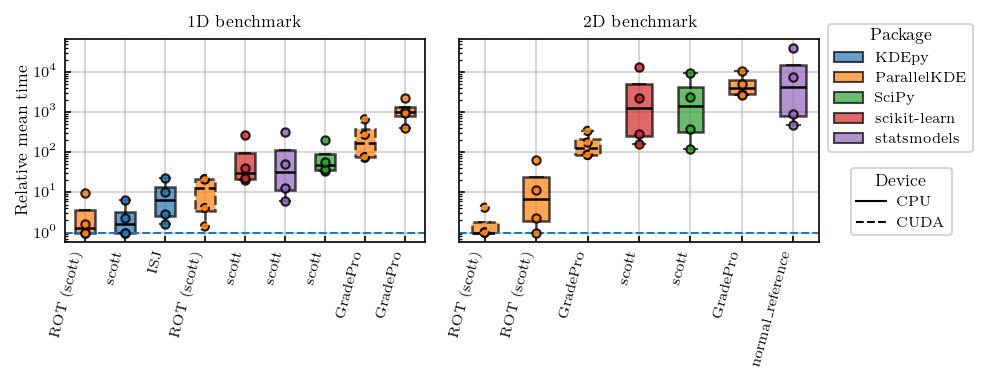

In [120]:
g = (
    sbenchmark_results.groupby(["dim", "sample_size", "package", "method", "device"], as_index=False)["total_time_s"].mean().rename(columns={"total_time_s": "mean_total_time"})
)
g["fastest_for_ss"] = g.groupby(["dim", "sample_size"])["mean_total_time"].transform("min")
g["rel_mean"] = g["mean_total_time"] / g["fastest_for_ss"]

dims = sorted(sbenchmark_results["dim"].dropna().unique())
packages = sorted(sbenchmark_results["package"].unique())
devices = sorted(sbenchmark_results["device"].unique())

base_colors = matplotlib.colormaps["tab10"]
pkg_colors = {p: base_colors(i) for i, p in enumerate(packages)}

ls_options = ["-", "--", ":", "-."]
dev_ls = {d: ls_options[i % len(ls_options)] for i, d in enumerate(devices)}

alpha_box = 0.7
alpha_points = 0.85
point_size = 16
jitter_sigma = 0.0

fig, axes = plt.subplots(1, 2, figsize=(5.6, 2.6), sharey=True)

for ax, d in zip(axes, dims):
    gd = g[g["dim"] == d]
    med = gd.groupby(["package", "method", "device"])["rel_mean"].median().sort_values()
    order = list(med.index)

    data = [
        gd[(gd["package"] == p) & (gd["method"] == m) & (gd["device"] == dev)]["rel_mean"].values
        for (p, m, dev) in order
    ]
    labels = [f"{p} | {m} | {dev}" for (p, m, dev) in order]

    bp = ax.boxplot(data, patch_artist=True, showfliers=False)

    for i, ((p, m, dev), box) in enumerate(zip(order, bp["boxes"])):
        color = pkg_colors[p]
        ls = dev_ls[dev]
        box.set(facecolor=color, alpha=alpha_box, edgecolor="black", linewidth=1.2, linestyle=ls)
        for w in (bp["whiskers"][2*i], bp["whiskers"][2*i+1]):
            w.set(color="black", alpha=alpha_box, linestyle=ls, linewidth=1.2)
        for c in (bp["caps"][2*i], bp["caps"][2*i+1]):
            c.set(color="black", alpha=alpha_box, linestyle=ls, linewidth=1.0)
        bp["medians"][i].set(color="black", linewidth=1.2, linestyle=ls)

    for i, vals in enumerate(data, start=1):
        p, m, dev = order[i-1]
        ax.scatter(
            [i]*len(vals), vals,
            s=point_size,
            alpha=alpha_points,
            color=pkg_colors[p],
            edgecolors="black",
            linestyle=dev_ls[dev],
            zorder=3,
        )

    ax.set_xticks(range(1, len(order)+1))
    ax.set_xticklabels([m for (_, m, _) in order], rotation=75, ha="right")
    
    ax.axhline(1.0, linestyle="--", linewidth=1)

    ax.set_yscale("log")
    
    ax.set_title(f"{d}D benchmark")
    if ax is axes[0]:
        ax.set_ylabel("Relative mean time")
    ax.tick_params(axis="x", rotation=75)
    ax.tick_params(which="both", top=False, right=False)

    ax.grid(alpha=0.6)

pkg_handles = [matplotlib.patches.Patch(facecolor=pkg_colors[p], alpha=alpha_box, edgecolor="black", label=p) for p in packages]
dev_handles = [matplotlib.lines.Line2D([0], [0], color="black", linestyle=dev_ls[d], label=d) for d in devices]
fig.legend(handles=pkg_handles, title="Package", loc="upper right", bbox_to_anchor=(1.17, 0.95), frameon=True)
fig.legend(handles=dev_handles, title="Device", loc="lower right", bbox_to_anchor=(1.145, 0.37), frameon=True)

fig.tight_layout()

# fig.savefig("benchmark_samples.pdf", dpi=500, bbox_inches="tight", pad_inches=0.02)

### Grid benchmark

In [84]:
gbenchmark_results = pd.read_csv("benchmark_grids.csv")

In [87]:
mapping = {
    "package": {"scipy": "SciPy", "sklearn": "scikit-learn", "kdepy": "KDEpy", "parallelkdepy": "ParallelKDE"},
    "device": {"cpu": "CPU", "cuda": "CUDA"},
    "method": {"rotEstimator": "ROT (scott)", "parallelEstimator": "GradePro"},
}
gbenchmark_results = gbenchmark_results.replace(mapping)

In [88]:
gbenchmark_results

,package,method,device,dim,sample_size,grid_points,fit_time_s,eval_time_s,total_time_s,ok
0,SciPy,scott,CPU,1,10000,100,0.000470,0.031724,0.032194,True
1,SciPy,scott,CPU,1,10000,100,0.000494,0.027847,0.028342,True
2,SciPy,scott,CPU,1,10000,100,0.000408,0.045340,0.045748,True
3,SciPy,scott,CPU,1,10000,100,0.000403,0.053010,0.053413,True
4,SciPy,scott,CPU,1,10000,100,0.000398,0.040743,0.041140,True
...,...,...,...,...,...,...,...,...,...,...
475,ParallelKDE,ROT (scott),CUDA,2,100000,300,0.000002,0.007326,0.007328,True
476,ParallelKDE,ROT (scott),CUDA,2,100000,300,0.000002,0.007236,0.007239,True
477,ParallelKDE,ROT (scott),CUDA,2,100000,300,0.000002,0.018303,0.018305,True
478,ParallelKDE,ROT (scott),CUDA,2,100000,300,0.000002,0.006690,0.006693,True


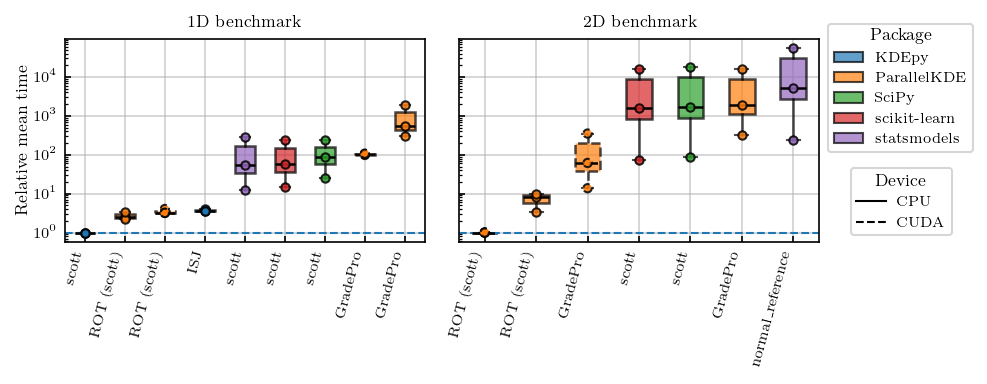

In [121]:
g = (
    gbenchmark_results.groupby(["dim", "grid_points", "package", "method", "device"], as_index=False)["total_time_s"].mean().rename(columns={"total_time_s": "mean_total_time"})
)
g["fastest_for_ss"] = g.groupby(["dim", "grid_points"])["mean_total_time"].transform("min")
g["rel_mean"] = g["mean_total_time"] / g["fastest_for_ss"]

dims = sorted(gbenchmark_results["dim"].dropna().unique())
packages = sorted(gbenchmark_results["package"].unique())
devices = sorted(gbenchmark_results["device"].unique())

base_colors = matplotlib.colormaps["tab10"]
pkg_colors = {p: base_colors(i) for i, p in enumerate(packages)}

ls_options = ["-", "--", ":", "-."]
dev_ls = {d: ls_options[i % len(ls_options)] for i, d in enumerate(devices)}

alpha_box = 0.7
alpha_points = 0.85
point_size = 16

fig, axes = plt.subplots(1, 2, figsize=(5.6, 2.6), sharey=True)

for ax, d in zip(axes, dims):
    gd = g[g["dim"] == d]
    med = gd.groupby(["package", "method", "device"])["rel_mean"].median().sort_values()
    order = list(med.index)

    data = [
        gd[(gd["package"] == p) & (gd["method"] == m) & (gd["device"] == dev)]["rel_mean"].values
        for (p, m, dev) in order
    ]
    labels = [f"{p} | {m} | {dev}" for (p, m, dev) in order]

    bp = ax.boxplot(data, patch_artist=True, showfliers=False)

    for i, ((p, m, dev), box) in enumerate(zip(order, bp["boxes"])):
        color = pkg_colors[p]
        ls = dev_ls[dev]
        box.set(facecolor=color, alpha=alpha_box, edgecolor="black", linewidth=1.2, linestyle=ls)
        for w in (bp["whiskers"][2*i], bp["whiskers"][2*i+1]):
            w.set(color="black", alpha=alpha_box, linestyle=ls, linewidth=1.2)
        for c in (bp["caps"][2*i], bp["caps"][2*i+1]):
            c.set(color="black", alpha=alpha_box, linestyle=ls, linewidth=1.0)
        bp["medians"][i].set(color="black", linewidth=1.2, linestyle=ls)

    for i, vals in enumerate(data, start=1):
        p, m, dev = order[i-1]
        ax.scatter(
            [i]*len(vals), vals,
            s=point_size,
            alpha=alpha_points,
            color=pkg_colors[p],
            edgecolors="black",
            linestyle=dev_ls[dev],
            zorder=3,
        )

    ax.set_xticks(range(1, len(order)+1))
    ax.set_xticklabels([m for (_, m, _) in order], rotation=75, ha="right")
    
    ax.axhline(1.0, linestyle="--", linewidth=1)

    ax.set_yscale("log")
    
    ax.set_title(f"{d}D benchmark")
    if ax is axes[0]:
        ax.set_ylabel("Relative mean time")
    ax.tick_params(axis="x", rotation=75)
    ax.tick_params(which="both", top=False, right=False)

    ax.grid(alpha=0.6)

pkg_handles = [matplotlib.patches.Patch(facecolor=pkg_colors[p], alpha=alpha_box, edgecolor="black", label=p) for p in packages]
dev_handles = [matplotlib.lines.Line2D([0], [0], color="black", linestyle=dev_ls[d], label=d) for d in devices]
fig.legend(handles=pkg_handles, title="Package", loc="upper right", bbox_to_anchor=(1.17, 0.95), frameon=True)
fig.legend(handles=dev_handles, title="Device", loc="lower right", bbox_to_anchor=(1.145, 0.37), frameon=True)

fig.tight_layout()

# fig.savefig("benchmark_grid.pdf", dpi=500, bbox_inches="tight", pad_inches=0.02)

## Plots (bar plots)

### Sample benchmark

In [3]:
sbenchmark_results = pd.read_csv("benchmark_samples.csv")

In [4]:
mapping = {
    "package": {"scipy": "SciPy", "sklearn": "scikit-learn", "kdepy": "KDEpy", "parallelkdepy": "ParallelKDE", "xentropy": "X-Entropy"},
    "device": {"cpu": "CPU", "cuda": "CUDA"},
    "method": {"rotEstimator": "ROT", "parallelEstimator": "GradePro", "scott": "ROT", "ISJ": "Plug-In", "normal_reference": "ROT", "botev": "Plug-In"},
}
sbenchmark_results = sbenchmark_results.replace(mapping)

In [5]:
sbenchmark_results

,package,method,device,dim,sample_size,grid_points,fit_time_s,eval_time_s,total_time_s,ok
0,SciPy,ROT,CPU,1,100,500,0.000276,0.009704,0.009980,True
1,SciPy,ROT,CPU,1,100,500,0.000182,0.009806,0.009988,True
2,SciPy,ROT,CPU,1,100,500,0.000171,0.004850,0.005021,True
3,SciPy,ROT,CPU,1,100,500,0.000176,0.008802,0.008978,True
4,SciPy,ROT,CPU,1,100,500,0.000226,0.006755,0.006981,True
...,...,...,...,...,...,...,...,...,...,...
675,ParallelKDE,ROT,CUDA,2,1000000,100,0.000002,0.015391,0.015393,True
676,ParallelKDE,ROT,CUDA,2,1000000,100,0.000002,0.015774,0.015776,True
677,ParallelKDE,ROT,CUDA,2,1000000,100,0.000002,0.015478,0.015480,True
678,ParallelKDE,ROT,CUDA,2,1000000,100,0.000002,0.014700,0.014702,True


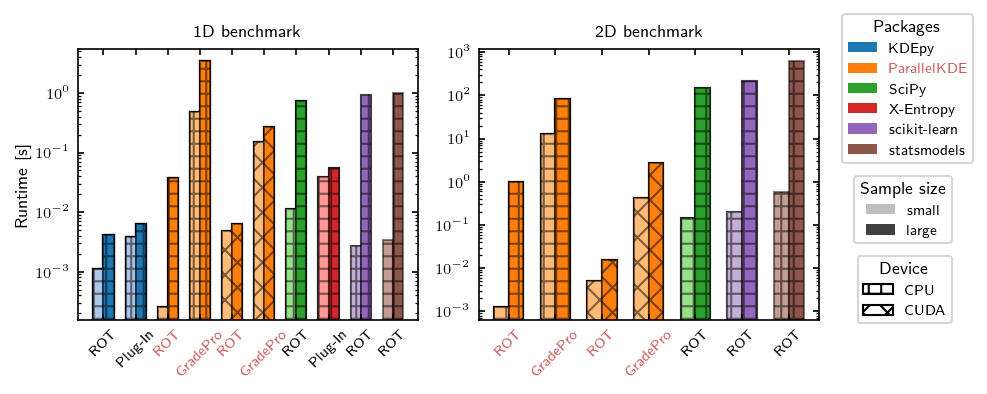

In [12]:
cmap = matplotlib.colormaps["tab20"]
hatches = ["++", "xx"]

packages = sbenchmark_results["package"].sort_values().unique()
devices = sbenchmark_results["device"].unique()
dims = sbenchmark_results["dim"].unique()
pkg_colors = {p: [cmap(2*i), cmap(2*i+1)] for i, p in enumerate(packages)}
dev_hatches = {d: hatches[i] for i, d in enumerate(devices)}

fig, axes = plt.subplots(1, 2, figsize=(5.6, 2.6))

for ax, dim in zip(axes, dims):
    dsub = sbenchmark_results[sbenchmark_results["dim"] == dim].copy()
    dsub_agg = dsub.groupby(["package", "method", "device", "sample_size"])["total_time_s"].mean().reset_index()

    min_size = dsub_agg["sample_size"].min()
    df_min = dsub_agg[dsub_agg["sample_size"] == min_size]
    max_size = dsub_agg["sample_size"].max()
    df_max = dsub_agg[dsub_agg["sample_size"] == max_size]

    sel = pd.concat([df_min, df_max], ignore_index=True)

    mean_by_pkg_meth_dev = sel.groupby(["package", "method", "device"])["total_time_s"].mean().reset_index()
    methods_by_pkg_dev = mean_by_pkg_meth_dev.sort_values(["package", "total_time_s"]).groupby(["package", "device"])["method"].apply(list).to_dict()

    bar_width = 0.38
    group_gap = 0.45
    package_gap = 0.0
    left_offset = -bar_width/2
    right_offset = bar_width/2

    x_positions, x_small, x_large = [], [], []
    heights_small, heights_large = [], []
    pkg_for_bar, xtick_labels = [], []
    dev_for_bar = []
    pkg_bands = []

    cursor = 0.0
    for pkg, dev in methods_by_pkg_dev:
        meths = methods_by_pkg_dev[pkg, dev]
        start_band = None
        for m in meths:
            x_center = cursor
            x_positions.append(x_center)
            x_small.append(x_center + left_offset)
            x_large.append(x_center + right_offset)

            v_small = sel[(sel["package"]==pkg) & (sel["method"]==m) & (sel["device"]==dev) & (sel["sample_size"]==min_size)]["total_time_s"]
            v_large = sel[(sel["package"]==pkg) & (sel["method"]==m) & (sel["device"]==dev) & (sel["sample_size"]==max_size)]["total_time_s"]
            heights_small.append(v_small.iloc[0])
            heights_large.append(v_large.iloc[0])

            pkg_for_bar.append(pkg)
            dev_for_bar.append(dev)
            xtick_labels.append(m)

            cursor += (2*bar_width + group_gap)

            if start_band is None:
                start_band = x_center - (bar_width + group_gap/2)
            end_band = x_center + (bar_width + group_gap/2)

        pkg_bands.append((start_band, end_band, pkg))
        cursor += package_gap

        bar_colors_small = [pkg_colors[pb][1] for pb in pkg_for_bar]
        bar_colors_large = [pkg_colors[pb][0] for pb in pkg_for_bar]
        bar_hatches = [dev_hatches[d] for d in dev_for_bar]

        ax.bar(x_small, heights_small, width=bar_width, edgecolor=(0, 0, 0, 0.5), color=bar_colors_small, hatch=bar_hatches)
        ax.bar(x_large, heights_large, width=bar_width, edgecolor=(0, 0, 0, 0.5), color=bar_colors_large, hatch=bar_hatches)

    ax.set_yscale("log")

    ax.set_title(f"{dim}D benchmark")

    ax.set_xticks(x_positions)
    ax.set_xticklabels(xtick_labels, rotation=45)

    labels = ax.get_xticklabels()
    if dim == 1:
        idx_to_color = {2: "indianred", 3: "indianred", 4: "indianred", 5: "indianred"}
    else:
        idx_to_color = {0: "indianred", 1: "indianred", 2: "indianred", 3: "indianred"}

    for i, t in enumerate(labels):
        if i in idx_to_color:
            t.set_color(idx_to_color[i])
            

    # ax.set_xlabel("Estimator")
    if dim == 1:
        ax.set_ylabel("Runtime [s]")

legend_colors = [pc[0] for pc in pkg_colors.values()]
color_labels = [pkg for pkg in pkg_colors]
color_handles = [matplotlib.patches.Patch(facecolor=legend_colors[i], label=color_labels[i]) for i in range(len(color_labels))]
pkg_leg = fig.legend(handles=color_handles, title="Packages", loc="upper right", frameon=True, bbox_to_anchor=(1.17, 1.0))
for txt_idx, txt in enumerate(pkg_leg.get_texts()):
    if txt_idx == 1:
        txt.set_color("indianred")

grey_handles = [matplotlib.patches.Patch(facecolor=fc, label=ls) for fc, ls in zip(["0.75", "0.25"], ["small", "large"])]
sample_leg = fig.legend(handles=grey_handles, title="Sample size", loc="center right", frameon=True, bbox_to_anchor=(1.145, 0.48))

hatch_handles = [matplotlib.patches.Patch(facecolor="white", edgecolor="black", hatch=h, label=ld) for h, ld in zip(["++", "xx"], ["CPU", "CUDA"])]
dev_leg = fig.legend(handles=hatch_handles, title="Device", loc="lower right", frameon=True, bbox_to_anchor=(1.145, 0.17))

# fig.savefig("benchmark_samples.pdf", dpi=500, bbox_inches="tight", pad_inches=0.02)

### Grid benchmark

In [7]:
gbenchmark_results = pd.read_csv("benchmark_grids.csv")

In [8]:
mapping = {
    "package": {"scipy": "SciPy", "sklearn": "scikit-learn", "kdepy": "KDEpy", "parallelkdepy": "ParallelKDE", "xentropy": "X-Entropy"},
    "device": {"cpu": "CPU", "cuda": "CUDA"},
    "method": {"rotEstimator": "ROT", "parallelEstimator": "GradePro", "scott": "ROT", "normal_reference": "ROT", "ISJ": "Plug-In", "botev": "Plug-In"},
}
gbenchmark_results = gbenchmark_results.replace(mapping)

In [9]:
gbenchmark_results

,package,method,device,dim,sample_size,grid_points,fit_time_s,eval_time_s,total_time_s,ok
0,SciPy,ROT,CPU,1,10000,100,0.000686,0.089885,0.090572,True
1,SciPy,ROT,CPU,1,10000,100,0.000371,0.061187,0.061558,True
2,SciPy,ROT,CPU,1,10000,100,0.000417,0.071457,0.071874,True
3,SciPy,ROT,CPU,1,10000,100,0.000388,0.039275,0.039663,True
4,SciPy,ROT,CPU,1,10000,100,0.000495,0.033374,0.033869,True
...,...,...,...,...,...,...,...,...,...,...
505,ParallelKDE,ROT,CUDA,2,100000,300,0.000002,0.007326,0.007328,True
506,ParallelKDE,ROT,CUDA,2,100000,300,0.000002,0.007236,0.007239,True
507,ParallelKDE,ROT,CUDA,2,100000,300,0.000002,0.018303,0.018305,True
508,ParallelKDE,ROT,CUDA,2,100000,300,0.000002,0.006690,0.006693,True


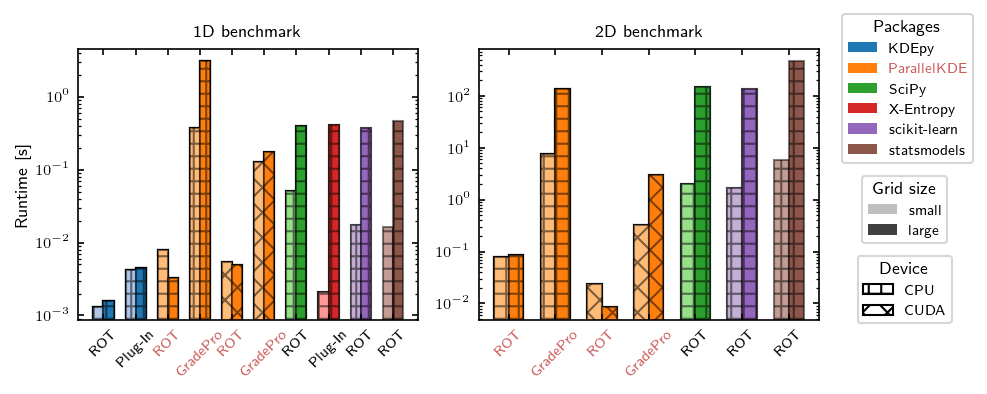

In [14]:
cmap = matplotlib.colormaps["tab20"]
hatches = ["++", "xx"]

packages = gbenchmark_results["package"].sort_values().unique()
devices = gbenchmark_results["device"].unique()
dims = gbenchmark_results["dim"].unique()
pkg_colors = {p: [cmap(2*i), cmap(2*i+1)] for i, p in enumerate(packages)}
dev_hatches = {d: hatches[i] for i, d in enumerate(devices)}

fig, axes = plt.subplots(1, 2, figsize=(5.6, 2.6))

for ax, dim in zip(axes, dims):
    dsub = gbenchmark_results[gbenchmark_results["dim"] == dim].copy()
    dsub_agg = dsub.groupby(["package", "method", "device", "grid_points"])["total_time_s"].mean().reset_index()

    min_size = dsub_agg["grid_points"].min()
    df_min = dsub_agg[dsub_agg["grid_points"] == min_size]
    max_size = dsub_agg["grid_points"].max()
    df_max = dsub_agg[dsub_agg["grid_points"] == max_size]

    sel = pd.concat([df_min, df_max], ignore_index=True)

    mean_by_pkg_meth_dev = sel.groupby(["package", "method", "device"])["total_time_s"].mean().reset_index()
    methods_by_pkg_dev = mean_by_pkg_meth_dev.sort_values(["package", "total_time_s"]).groupby(["package", "device"])["method"].apply(list).to_dict()

    bar_width = 0.38
    group_gap = 0.45
    package_gap = 0.0
    left_offset = -bar_width/2
    right_offset = bar_width/2

    x_positions, x_small, x_large = [], [], []
    heights_small, heights_large = [], []
    pkg_for_bar, xtick_labels = [], []
    dev_for_bar = []
    pkg_bands = []

    cursor = 0.0
    for pkg, dev in methods_by_pkg_dev:
        meths = methods_by_pkg_dev[pkg, dev]
        start_band = None
        for m in meths:
            x_center = cursor
            x_positions.append(x_center)
            x_small.append(x_center + left_offset)
            x_large.append(x_center + right_offset)

            v_small = sel[(sel["package"]==pkg) & (sel["method"]==m) & (sel["device"]==dev) & (sel["grid_points"]==min_size)]["total_time_s"]
            v_large = sel[(sel["package"]==pkg) & (sel["method"]==m) & (sel["device"]==dev) & (sel["grid_points"]==max_size)]["total_time_s"]
            heights_small.append(v_small.iloc[0])
            heights_large.append(v_large.iloc[0])

            pkg_for_bar.append(pkg)
            dev_for_bar.append(dev)
            xtick_labels.append(m)

            cursor += (2*bar_width + group_gap)

            if start_band is None:
                start_band = x_center - (bar_width + group_gap/2)
            end_band = x_center + (bar_width + group_gap/2)

        pkg_bands.append((start_band, end_band, pkg))
        cursor += package_gap

        bar_colors_small = [pkg_colors[pb][1] for pb in pkg_for_bar]
        bar_colors_large = [pkg_colors[pb][0] for pb in pkg_for_bar]
        bar_hatches = [dev_hatches[d] for d in dev_for_bar]

        ax.bar(x_small, heights_small, width=bar_width, edgecolor=(0, 0, 0, 0.5), color=bar_colors_small, hatch=bar_hatches)
        ax.bar(x_large, heights_large, width=bar_width, edgecolor=(0, 0, 0, 0.5), color=bar_colors_large, hatch=bar_hatches)

    ax.set_yscale("log")

    ax.set_title(f"{dim}D benchmark")

    ax.set_xticks(x_positions)
    ax.set_xticklabels(xtick_labels, rotation=45)

    labels = ax.get_xticklabels()
    if dim == 1:
        idx_to_color = {2: "indianred", 3: "indianred", 4: "indianred", 5: "indianred"}
    else:
        idx_to_color = {0: "indianred", 1: "indianred", 2: "indianred", 3: "indianred"}

    for i, t in enumerate(labels):
        if i in idx_to_color:
            t.set_color(idx_to_color[i])
            

    # ax.set_xlabel("Estimator")
    if dim == 1:
        ax.set_ylabel("Runtime [s]")

legend_colors = [pc[0] for pc in pkg_colors.values()]
color_labels = [pkg for pkg in pkg_colors]
color_handles = [matplotlib.patches.Patch(facecolor=legend_colors[i], label=color_labels[i]) for i in range(len(color_labels))]
pkg_leg = fig.legend(handles=color_handles, title="Packages", loc="upper right", frameon=True, bbox_to_anchor=(1.17, 1.0))
for txt_idx, txt in enumerate(pkg_leg.get_texts()):
    if txt_idx == 1:
        txt.set_color("indianred")

grey_handles = [matplotlib.patches.Patch(facecolor=fc, label=ls) for fc, ls in zip(["0.75", "0.25"], ["small", "large"])]
sample_leg = fig.legend(handles=grey_handles, title="Grid size", loc="center right", frameon=True, bbox_to_anchor=(1.14, 0.48))

hatch_handles = [matplotlib.patches.Patch(facecolor="white", edgecolor="black", hatch=h, label=ld) for h, ld in zip(["++", "xx"], ["CPU", "CUDA"])]
dev_leg = fig.legend(handles=hatch_handles, title="Device", loc="lower right", frameon=True, bbox_to_anchor=(1.145, 0.17))

# fig.savefig("benchmark_grids.pdf", dpi=500, bbox_inches="tight", pad_inches=0.02)